# A/B testing user preference simulation 

## John Burt

### Purpose of this notebook

This notebook came out of discussions over how our Data Science meetup group could host an A/B testing workshop. The problem is that A/B testing is an iterative experimentation and data collection process: you present users with a website configured in two different ways, record their response (Click Throughs, Conversions, etc), compare the responses, make improvements and then conduct another experiment, etc. So, if you want people to learn and explore A/B testing, you can't just provide a static dataset - you need to provide a simulation environment that testers can probe with their own A/B tests. 

### Here are the features of the A/B testing simulation I came up with:

**The simulation would be presented as a challenge to "testers" via a web app or microservice API.** Testers would be allowed to conduct experiments by submitting website element configurations and receiving samples of simulated user responses (click throughs, conversions, etc). They would conduct multiple trials to collect response samples and determine the underlying preferences and optimize the response.

**The simulation emulates a population of users who have pre-defined preferences for the website elements that will be tested.** For example, given red, green and blue as background colors, we can specify that users tend to dislike red and green, and prefer blue backgrounds. 


**Simulated user preferences are modeled on a normal distribution.** Preference for each element level (e.g., "blue background") is specified by two terms: mean and variance. When a sim-user is tested in a trial, their preferences are randomly selected based on the distribution described by those terms. This results in a more stochastic and realistic distribution of responses.

**A sim-user's overall website preference score is based on the average of its preferences for all of the website element levels it's presented with.** 

**An importance factor is applied when generating responses.** Only a fraction of a real user's decision to click on a buy button will be due to the website design. I call this factor importance: if the website design is very influential, then importance will be higher.

**Response is calculated using a simple threshold.** If the final score is higher than the defined response threshold, then the result will be positive, otherwise negative.



In [71]:
from IPython.display import HTML

HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''')

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import norm, skewnorm
from matplotlib import pyplot as plt

## Define the simulator model configuration

The model simulates a user visiting a website and making a choice based on their combined preferences for the design elements of the website. The preferences structure defines user preferences for each site design element, and other model details.

### Details:

- **importance:** (range 0-1) How much preference score influences the response output vs unknown random factors. An importance of 1 means response is entirely dependent on preference score, while importance of 0 means response will be entirely random.


- **elements:** Web site elements that represent the items a tester can manipulate.  
    - **weight:** each element contributes a specified amount to the overall preference score for the web page. 

    - **levels:** Each element can have two or more levels. For example, a web page background can be one of three colors: red, green or blue. Each attribute uses a unique probability distribution to define the preference a simulated user has for it. The preferences of a sim-user will be set based on these distributions. For example, most people don't like red backgrounds, so that attribute has a mean of 0 (least favored) and variance of 0.2. 


- **response:** The response variable testers are measuring during a trial. The response will be binary and output will be based on comparing the overall preference score with a defined threshold. 


In [61]:
default_var = 0.2 # default variance

preferences = {
    'importance': 0.5, # how much preference score influences the response
    
    # elements = independent variables the tester can manipulate.
    #   For example: website elements, CTA, etc
    'elements': {
        'back_color': {'weight':1, 'levels': {
            'blue': {'mean':1, 'var':default_var}, 
            'red': {'mean':0, 'var':default_var},
            'green': {'mean':0.5, 'var':default_var},
        } },
        
        'button_1': {'weight':0.5, 'levels': {
             'shown': {'mean':1, 'var':0.5},
             'hidden': {'mean':0, 'var':0.5} } },
        
        'num_images': {'weight':1, 'levels': { 
                       '5':{'mean':0.5, 'var':default_var}, 
                       '10':{'mean':1.0, 'var':default_var}, 
                       '15':{'mean':0.6, 'var':default_var}, 
                       '20':{'mean':0.4, 'var':default_var}, 
                      } },
    
        'image_size': {'weight':1, 'levels': { 
                       '50':{'mean':0.1, 'var':default_var}, 
                       '100':{'mean':0.6, 'var':default_var}, 
                       '250':{'mean':1.0, 'var':default_var}, 
                       '500':{'mean':0.3, 'var':default_var}, 
                      } },
        },
    
    # response = the dependent variable, or output, being measured.
    #  For example: click through, conversion, etc
    'response': {'name':'conversion', 'type':'binary', 'thresh':0.8, 'range':[0,1]}
    }


## Define the experimental trial configurations

The trial structure defines the design element levels that will be presented for each experimental trial.

In [62]:
# A set of three site attribute configs that define each trial condition.
trials = [ 
    {'back_color': 'blue','button_1': 'hidden', 'num_images': '5', 
     'image_size': '50', 'noise':'noise' },
    
    {'back_color': 'red','button_1': 'shown', 'num_images': '15', 
     'image_size': '250', 'noise':'noise' },
    
    {'back_color': 'green','button_1': 'shown', 'num_images': '10', 
     'image_size': '500', 'noise':'noise' },
    ]


## Get sim-user preference score for individual design elements

Generate a preference value from a distribution to use as a user's preference for a given design element. 

The sample is taken from a normal distributon with defined mean and variance. Preferences range from 0 - 1, with 0 being most disliked and 1 being most favored. By adjusting the mean and variance parameters, testers can create a range of different simulated preference distributions.



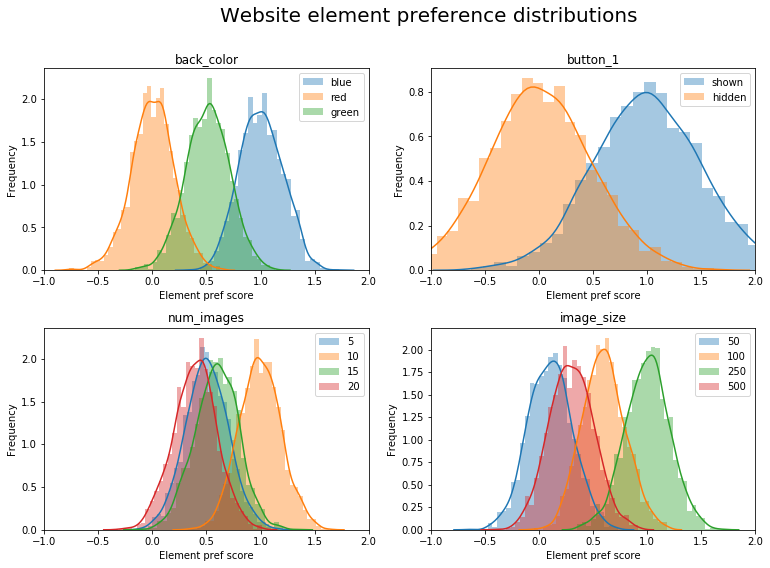

In [63]:
def sample_from_dist(params, limit='unbounded', bounds=None):
    """Calculate a value based on a random distribution specified in params
        params['mean']: mean of normal distribution
        params['var']: variance of normal distribution
    """
    return (np.random.randn() * params['var']) +  params['mean']
    
def sample_element_preferences(params, n_samps):
    """helper for making figures"""
    return [sample_from_dist(params) for i in range(n_samps)]
    
 
# test the model output at the element level
if True:
    nsamps = 2000
    n_elements = len(preferences['elements'])
    ncols = 2
    nrows = 2
    xrange = [-1, 2]
    
    plt.figure(figsize=[nrows*6,ncols*4])
    plt.suptitle('Website element preference distributions', fontsize=20)

    for i,(elkey,states) in zip(range(n_elements),
                               preferences['elements'].items()):
        plt.subplot(nrows,ncols,i+1)
        for statekey,state in states['levels'].items():
            scores = sample_element_preferences(state, n_samps=nsamps)
            sns.distplot(scores, label=statekey)
        plt.title('Element: %s'%(elkey));
        plt.title(elkey)
        plt.xlabel('Element pref score')
        plt.ylabel('Frequency')
        plt.xlim(xrange[0], xrange[1])
        plt.legend();
        plt.tight_layout(rect=[0, 0, .90, 0.92]);
 

## Overall preference score for a given site configuration

Next I combine the user's preferences for each design element into an overall preference score that the user would give to the site. This would be roughly equivalent to a rating in the range of 0-1 of how much the sim-user was motivated to give a positive response. 


In [70]:
def range_value(val, valrange):
    """range value from 0-1 to valrange[minval, maxval]"""
    return val * (valrange[1]-valrange[0]) + valrange[0]

def derange_value(val, valrange):
    """range value from valrange[minval, maxval] to 0-1"""
    return (val-valrange[0]) / (valrange[1]-valrange[0])

def combined_pref_score(ivparams, expvs):
    """Generate a weighted overall preference score"""
    valsum = 0
    wtsum = 0
    for name,param in ivparams.items():
        pref = sample_from_dist(param['levels'][expvs[name]])
        valsum += pref * param['weight']
        wtsum += param['weight'] 
    return valsum / wtsum

if True:
    # test calc a preference score from a single consumer
    print('test preference score:',
          combined_pref_score(preferences['elements'], trials[1]))
    

test preference score: 0.6731519620726798


## Calculate a user's response

This function converts the overall site preference score into the actual response to the site. The response is what you would be measuring in an actual trial, for example whether the user clicked on a buy button. 

Response is calculated based on three factors:

- **preference score:** how much does the user like the website design? Think of this as an internal rating of the site design, which is what you want to maximize to influense the response.


- **importance:** how important is the site design toward influencing the response? It could be very important, or not important at all. The importance level is set in preferences and is used to create a weighted a mix of preference score + random value: 
    - $adjusted\_score = score*importance + random\_value*(1-importance)$


- **response threshold:** given an importance-adjusted score, what is the threshold above which a positive response is given?

**NOTE:** I've included code to allow for a continuous response (e.g., "time on page"), but my model doesn't handle that yet.

In [65]:
def get_response(score, resp_cfg):
    """convert a preference score into an output response"""
    if resp_cfg['type'] == 'binary':
        return (resp_cfg['range'][0] if score < resp_cfg['thresh'] 
                else resp_cfg['range'][1])
    elif resp_cfg['type'] == 'continuous':
        # increasing preference = increasing output values 
        if resp_cfg['range'][0] <= resp_cfg['range'][1]:
            return (score * 
                    (resp_cfg['range'][1]-resp_cfg['range'][0]) +
                    resp_cfg['range'][0] )
        # increasing preference = DEcreasing output values 
        else:
            return (-(1-score) * 
                    (resp_cfg['range'][0]-resp_cfg['range'][1]) +
                    resp_cfg['range'][0] )
    return 0
            

## Run a trial

A trial is a preference test measuring responses to a single configuration of website elements.

The trial returns a specified number of sim-user test results: 


- scores = the overall site preference score for the site configuration, as if you has asked them to rate the site (this would not be collected in a real A/B test, but is useful for diagnostics).


- responses = the actual response to the site, defined by the dependent variable parameters. For example, this could be the conversion true/false response.


In [66]:
def run_trial(preferences, trial, n_samples):    
    """Run one experimental trial"""
    scores = []
    responses = []
    # sample responses from simulated users
    for i in range(n_samples):
        score = combined_pref_score(preferences['elements'], trial)
        scores.append(score)
        adj_score = (score*preferences['importance'] + 
                     np.random.rand()*(1-preferences['importance']) )
        responses.append(get_response(adj_score,
                                      preferences['response']))
    return scores, responses

## Test the model output for three different site designs

For this test I chose three different site element configurations. 
- Trial 1 represents the lowest response to the site, based on the preference setup I created in the preferences structure. That is, I selected the least preferred site elements. I would expect the conversion rate to be very low for this test.


- Trial 2 uses elements with mid level preferences. It should have a medium level preference response, with a middling conversion rate.


- Trial 3 uses the most preferred design elements and should give the best preference response and conversion rate.



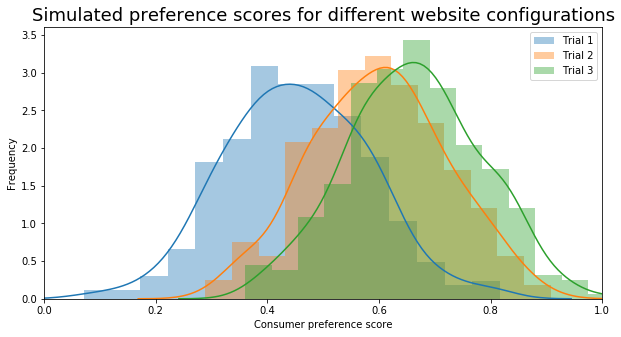

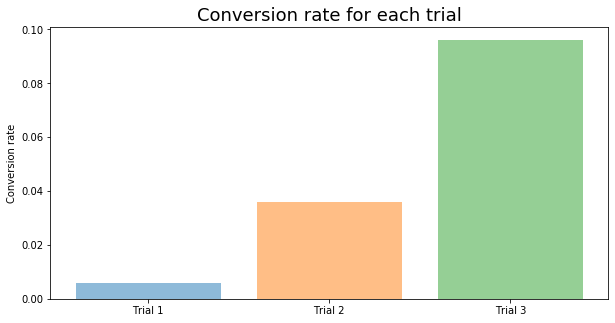

In [67]:
n_trials = len(trials)
n_samples_total = 1000
n_samps_trial = int(n_samples_total/n_trials)

plt.figure(figsize=[10,5])
defcolors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.title('Simulated preference scores for different website configurations',
         fontsize=18)
plt.xlabel('Consumer preference score')
plt.ylabel('Frequency')

# collect preference and response data for each trial config
trial_CRs = []
colors = []
for trialnum,trial in enumerate(trials):
    scores, responses = run_trial(preferences, trial, n_samps_trial)
    ax = sns.distplot(scores, label='Trial %d'%(trialnum+1))
    plt.xlim(0, 1)
    trial_CRs.append(np.sum(responses) / len(responses))
plt.legend();

plt.figure(figsize=[10,5])
plt.title('Conversion rate for each trial',fontsize=18)
plt.ylabel('Conversion rate')
x = np.arange(n_trials)
plt.bar(x,trial_CRs, color=defcolors, alpha=.5)
plt.xticks(x, ['Trial '+str(tn+1) for tn in x]);
